## Fitting Min 7-Day Average Flow Data from Russian River Basins to a Pearson-III Distribution Using the Method of Moments to Quantify Extremeness of Years
by Arman Omidvar

In [27]:
import numpy as np
import pandas as pd
from scipy.stats import pearson3
import matplotlib.pyplot as plt
from scipy.special import gammaln

We again use a Pearson-III distribution (this time not log adjusted) as is advised by the USGS

Matalas, Nicholas C. Probability distribution of low flows. US Government Printing Office, 1963.

In [28]:
def sample_mean(low_flows):
    return np.mean(low_flows)

def sample_std(low_flows):
    return np.std(low_flows, ddof=1)

def sample_skew(low_flows):
    n = len(low_flows)
    mean = sample_mean(low_flows)
    m3 = np.sum((low_flows - mean) ** 3) / n
    m2 = sample_std(low_flows) ** 2 * (n - 1) / n
    skewness = m3 / (m2 ** 1.5)
    return skewness

In [29]:
def pearsonIII_alpha_estimate(sample_skew):
    """
    Compute the MOM estimate of the alpha parameter for a Pearson-III distribution based on the weighted skew.
    """
    alpha = (4 / (sample_skew ** 2))
    return alpha

def pearsonIII_beta_estimate(sample_skew, standard_error, alpha_hat):
    """
    Compute the MOM estimate of the beta parameter for a Pearson-III distribution.
    """
    beta_hat = np.sign(sample_skew) * (standard_error ** 2 / alpha_hat) ** 0.5
    return beta_hat

def pearsonIII_tau_estimate(mean_log_peak_flows, beta_hat, alpha_hat):
    """
    Compute the MOM estimate of the tau parameter for a Pearson-III distribution.
    """
    tau_hat = mean_log_peak_flows - (alpha_hat * beta_hat)
    return tau_hat

Basin: Calpella
alpha_hat: 132.203715913663, beta_hat: -2.826247068918145, tau_hat: 427.52209529631506


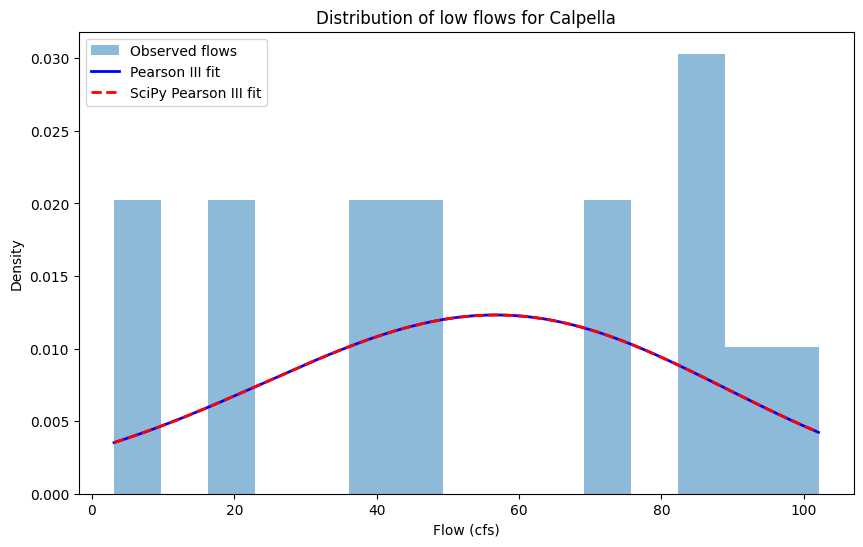

C:\Users\arman\AppData\Local\Temp\ipykernel_27032\1624653184.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data[basin]['Date'] = pd.to_datetime(all_data[basin]['Date'])


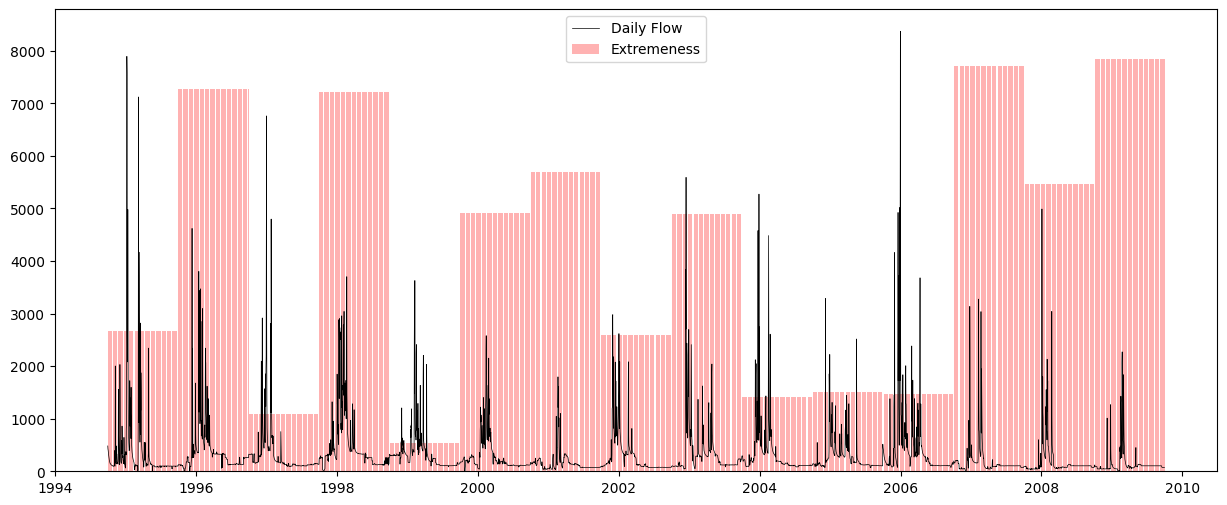

Basin: Guerneville
alpha_hat: 116.21520977187137, beta_hat: 4.469784697738843, tau_hat: -286.12115199710735


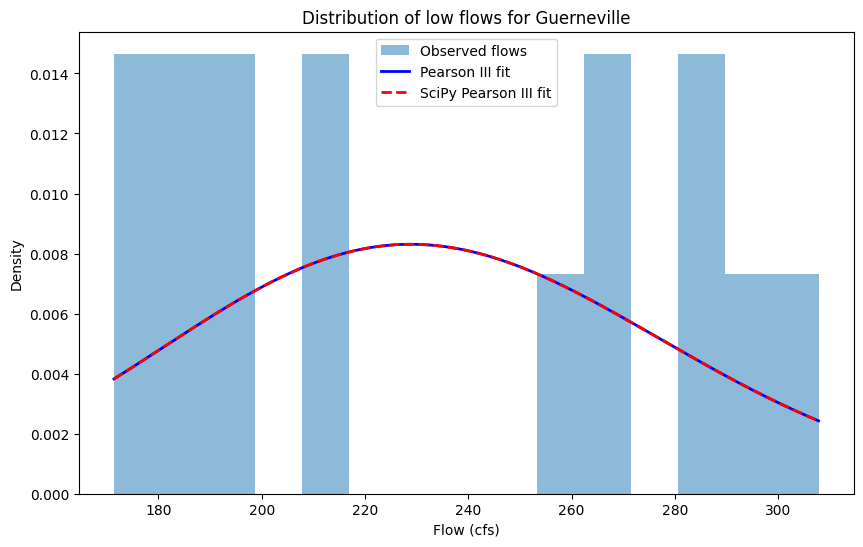

C:\Users\arman\AppData\Local\Temp\ipykernel_27032\1624653184.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data[basin]['Date'] = pd.to_datetime(all_data[basin]['Date'])


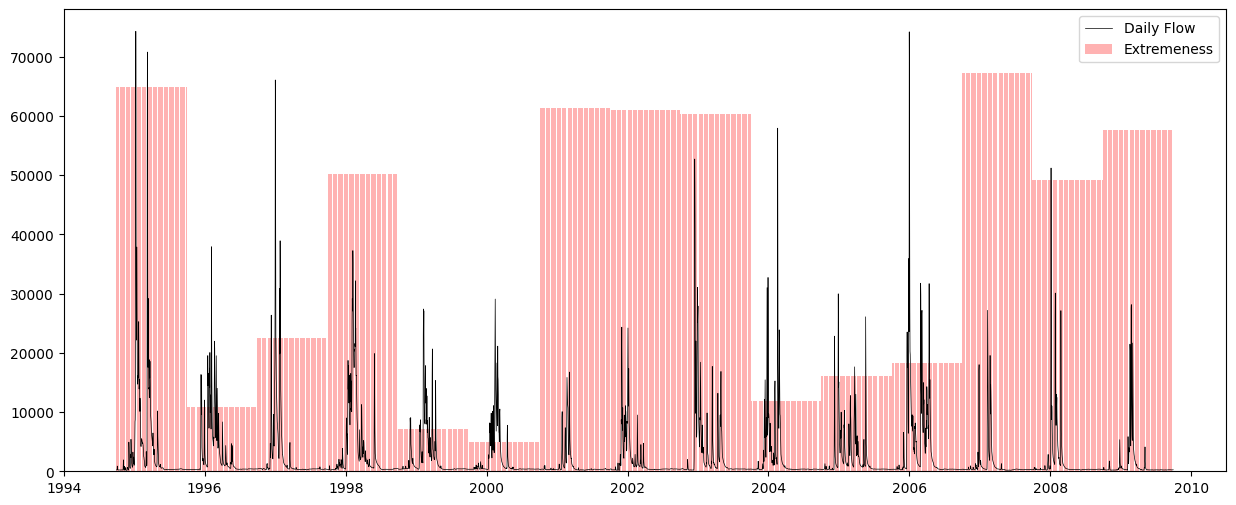

Basin: Hopland
alpha_hat: 40.80318507575343, beta_hat: 7.253865554883587, tau_hat: -172.27870541721376


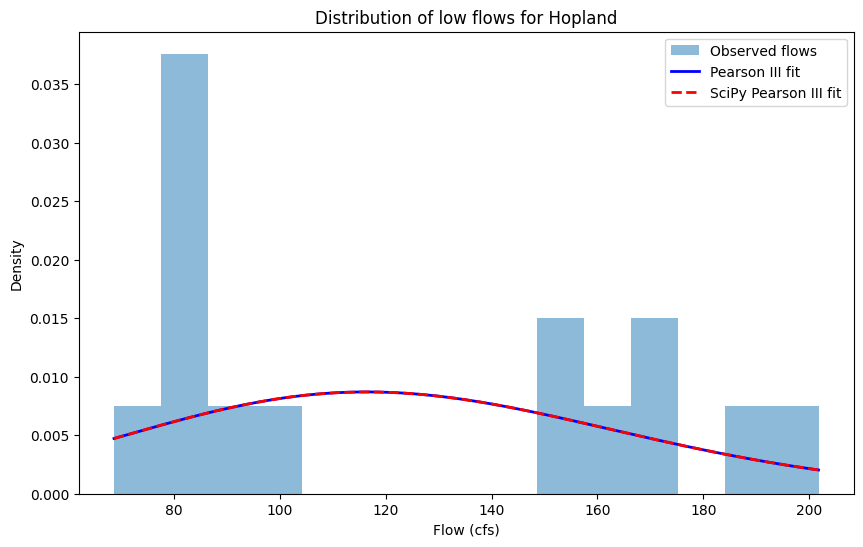

C:\Users\arman\AppData\Local\Temp\ipykernel_27032\1624653184.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data[basin]['Date'] = pd.to_datetime(all_data[basin]['Date'])


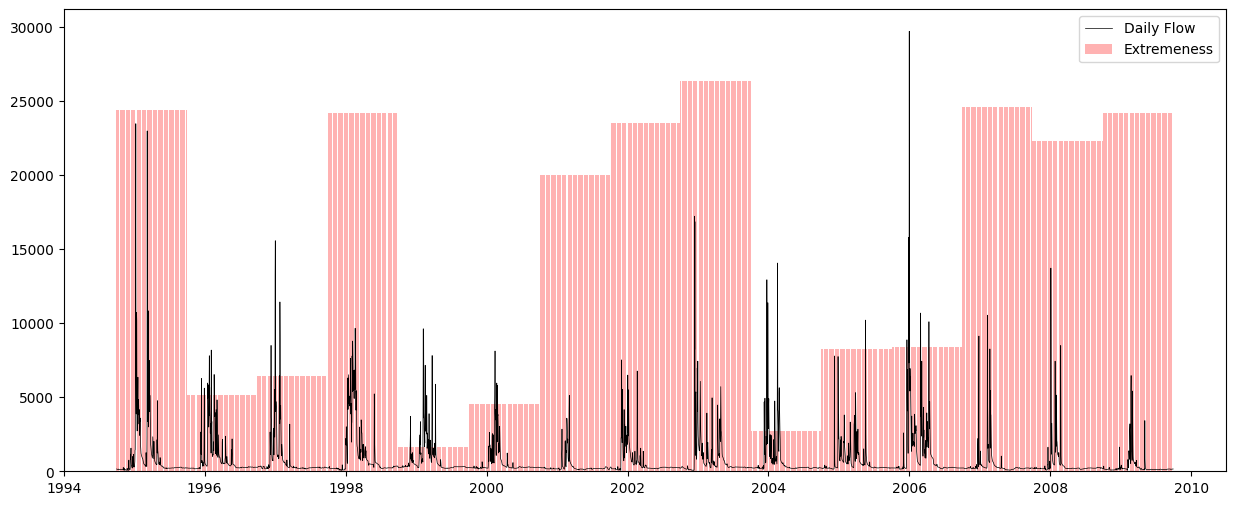

Basin: Warm Springs
alpha_hat: 725.564766779001, beta_hat: 0.3947343663046137, tau_hat: -229.61234839889212


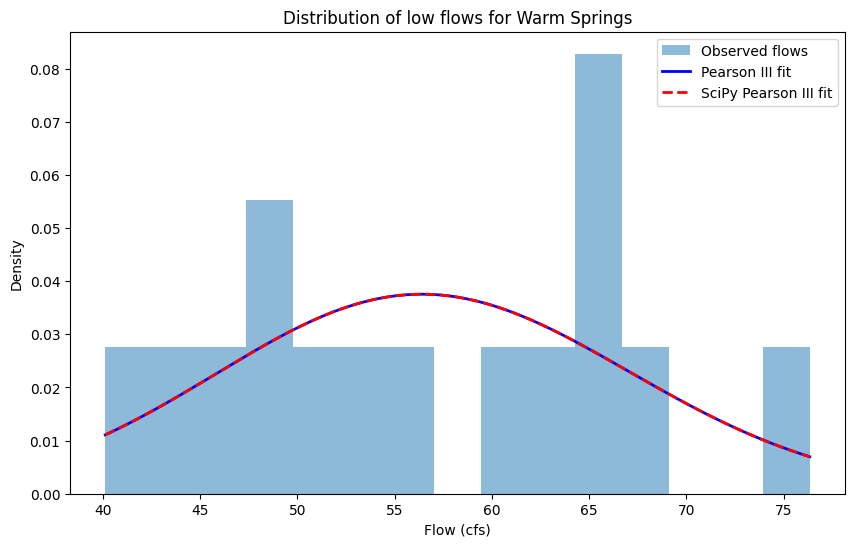

C:\Users\arman\AppData\Local\Temp\ipykernel_27032\1624653184.py:73: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  all_data[basin]['Date'] = pd.to_datetime(all_data[basin]['Date'])


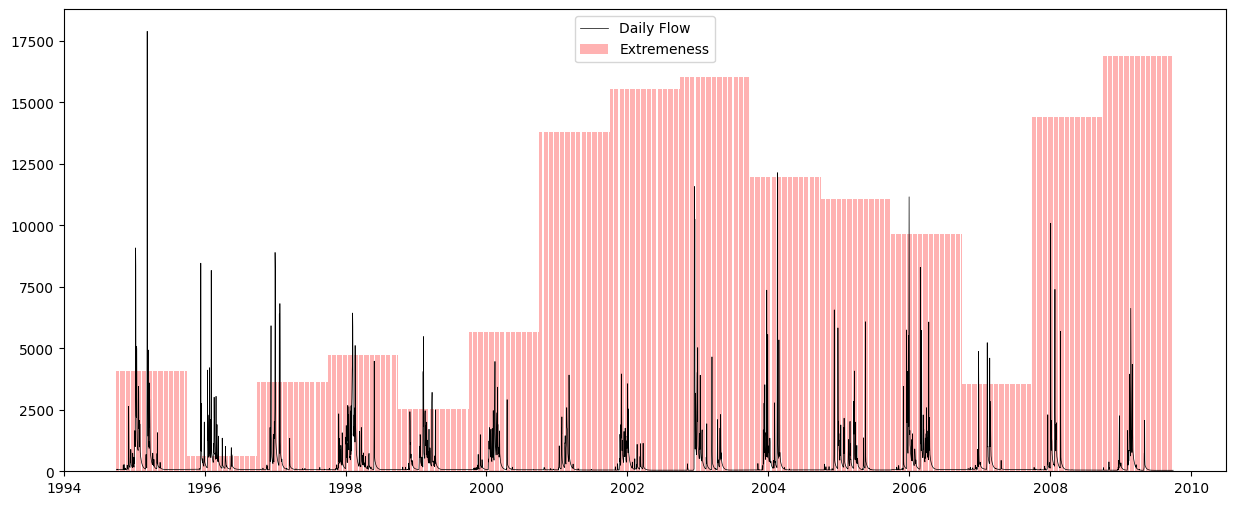

In [30]:
calpella_low_flows = pd.read_csv('russian_river_low_flows/Calpella.csv')
guerneville_low_flows = pd.read_csv('russian_river_low_flows/Guerneville.csv')
hopland_low_flows = pd.read_csv('russian_river_low_flows/Hopland.csv')
warmsprings_low_flows = pd.read_csv('russian_river_low_flows/Warm.csv')

calpella_all_data = pd.read_csv('russian_river_data/Calpella_daily.csv')
guerneville_all_data = pd.read_csv('russian_river_data/Guerneville_daily.csv')
hopland_all_data = pd.read_csv('russian_river_data/Hopland_daily.csv')
warmsprings_all_data = pd.read_csv('russian_river_data/WarmSprings_Inflow_daily.csv')


low_flows = {'Calpella': calpella_low_flows['mav'].values,
              'Guerneville': guerneville_low_flows['mav'].values,
              'Hopland': hopland_low_flows['mav'].values,
              'Warm Springs': warmsprings_low_flows['mav'].values}

all_data = {'Calpella': calpella_all_data,
            'Guerneville': guerneville_all_data,
            'Hopland': hopland_all_data,
            'Warm Springs': warmsprings_all_data}


extreme_years = pd.DataFrame()
extreme_years['water_year'] = calpella_low_flows['water_year']


def pearson3_pdf(x, alpha, beta, tau):
    x = np.asarray(x, dtype=float)

    if alpha <= 0 or beta == 0:
        return np.full_like(x, np.nan)

    z = (x - tau) / beta
    mask = z > 0

    out = np.zeros_like(x, dtype=float)
    logpdf = -np.log(abs(beta)) - gammaln(alpha) + (alpha - 1)*np.log(z[mask]) - z[mask]
    out[mask] = np.exp(logpdf)
    return out

for basin in low_flows.keys():
    basin_low_flows = low_flows[basin]
    sam_skew = sample_skew(basin_low_flows)

    mean_flows = np.mean(basin_low_flows)
    std_flows = np.std(basin_low_flows, ddof=1)

    alpha_hat = pearsonIII_alpha_estimate(sam_skew)
    beta_hat = pearsonIII_beta_estimate(sam_skew, std_flows, alpha_hat)
    tau_hat = pearsonIII_tau_estimate(mean_flows, beta_hat, alpha_hat)

    print(f'Basin: {basin}')
    print(f'alpha_hat: {alpha_hat}, beta_hat: {beta_hat}, tau_hat: {tau_hat}')

    dist = pearson3(sam_skew, loc=mean_flows, scale=std_flows)
    x = np.linspace(min(basin_low_flows), max(basin_low_flows), 200)
    scipy_pdf_vals = dist.pdf(x)
    my_pdf_vals = pearson3_pdf(x, alpha_hat, beta_hat, tau_hat)

    extreme_years[basin] = 1 - dist.cdf(basin_low_flows)

    plt.figure(figsize=(10, 6))
    plt.hist(basin_low_flows, bins=15, density=True, alpha=0.5, label='Observed flows')
    plt.plot(x, my_pdf_vals, 'b-', lw=2, label='Pearson III fit')
    plt.plot(x, scipy_pdf_vals, 'r--', lw=2, label='SciPy Pearson III fit')
    plt.xlabel('Flow (cfs)')
    plt.ylabel('Density')
    plt.title(f'Distribution of low flows for {basin}')
    plt.legend()
    plt.show()


    all_data[basin]['Date'] = pd.to_datetime(all_data[basin]['Date'])
    low_flow_df = all_data[basin].copy()
    low_flow_df['water_year'] = np.where(low_flow_df['Date'].dt.month >= 10, low_flow_df['Date'].dt.year + 1, low_flow_df['Date'].dt.year)
    low_flow_df['low_flow'] = None
    low_flow_df['extremeness'] = None
    for i, year in enumerate(low_flow_df['water_year'].unique()):
        low_flow_df.loc[low_flow_df['water_year'] == year, 'low_flow'] = basin_low_flows[i]
        low_flow_df.loc[low_flow_df['water_year'] == year, 'extremeness'] = extreme_years[basin].iloc[i]


    plt.figure(figsize=(15, 6))
    plt.bar(
        low_flow_df['Date'],
        low_flow_df['extremeness'] * max(all_data[basin].iloc[:, 3]),
        color="red",
        alpha=0.3,
        label="Extremeness"
    )

    plt.plot(
        all_data[basin]['Date'],
        all_data[basin].iloc[:, 3],
        color="black",
        linewidth=0.5,
        label="Daily Flow",
    )

    plt.legend()
    plt.show()

In [31]:
extreme_years.to_csv('low_flow_analysis.csv', index=False)
print(extreme_years)

    water_year  Calpella  Guerneville   Hopland  Warm Springs
0         1995  0.318317     0.872956  0.820051      0.226931
1         1996  0.868436     0.145998  0.173123      0.035034
2         1997  0.129586     0.302165  0.215624      0.202773
3         1998  0.862311     0.674567  0.814643      0.264425
4         1999  0.063974     0.096678  0.054101      0.140596
5         2000  0.587572     0.065706  0.153473      0.316169
6         2001  0.679554     0.826679  0.673029      0.772205
7         2002  0.310520     0.820676  0.791227      0.867984
8         2003  0.584624     0.811359  0.887890      0.896087
9         2004  0.169212     0.158692  0.090419      0.668624
10        2005  0.180570     0.216848  0.277395      0.619251
11        2006  0.175661     0.246291  0.281693      0.539611
12        2007  0.922167     0.904805  0.828119      0.198328
13        2008  0.653102     0.660887  0.750295      0.806152
14        2009  0.936464     0.775617  0.813933      0.943822


In [32]:
basins = [col for col in extreme_years.columns if col != "water_year"]

for basin in basins:
    print(f"\n=== {basin} (lowest → highest extremeness) ===")
    
    ranked = (
        extreme_years[["water_year", basin]]
        .sort_values(by=basin, ascending=True)  # lowest = most extreme
        .reset_index(drop=True)
    )
    
    ranked["rank"] = ranked.index + 1
    
    print(ranked[["rank", "water_year", basin]])


=== Calpella (lowest → highest extremeness) ===
    rank  water_year  Calpella
0      1        1999  0.063974
1      2        1997  0.129586
2      3        2004  0.169212
3      4        2006  0.175661
4      5        2005  0.180570
5      6        2002  0.310520
6      7        1995  0.318317
7      8        2003  0.584624
8      9        2000  0.587572
9     10        2008  0.653102
10    11        2001  0.679554
11    12        1998  0.862311
12    13        1996  0.868436
13    14        2007  0.922167
14    15        2009  0.936464

=== Guerneville (lowest → highest extremeness) ===
    rank  water_year  Guerneville
0      1        2000     0.065706
1      2        1999     0.096678
2      3        1996     0.145998
3      4        2004     0.158692
4      5        2005     0.216848
5      6        2006     0.246291
6      7        1997     0.302165
7      8        2008     0.660887
8      9        1998     0.674567
9     10        2009     0.775617
10    11        2003     0.81